# Some experimental Wildfire charts

In [16]:
%matplotlib inline

import requests 
import json
import pandas as pd
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np

headers = {'ContentType': 'json'}

#### Get daily precipitation data

In [17]:
params = {'g': 'POINT(-119.5383+37.8651)'}

In [18]:
pr_rcp45 = None

url = 'http://api.cal-adapt.org/api/series/pr_day_CNRM-CM5_rcp45/rasters/?g=POINT(-119.5383+37.8651)'
response = requests.get(url, headers=headers)
if response.ok:
    json = response.json()
    data = json['results'][0]
    # Get start date of timeseries
    start_date = datetime.strptime(data['event'], '%Y-%m-%d')
    # Get values - 3D array
    values_list = data['image']
    # Flatten list
    flattened_list = list(chain.from_iterable(values_list))
    # Get total number of values -> number of days
    length = len(flattened_list)
    # Create new pandas dataframe and map each value in list to a date index
    pr_rcp45 = pd.DataFrame(flattened_list,
        index=pd.date_range(start_date, freq='1D', periods=length),
        columns=['pr'])
    # Convert units from kg/m2/s to inch/day
    pr_rcp45['pr'] = pr_rcp45['pr'] * 86400 * 0.0393701
    print(pr_rcp45.head())

             pr
2006-01-01  0.0
2006-01-02  0.0
2006-01-03  0.0
2006-01-04  0.0
2006-01-05  0.0


In [22]:
pr_hist = None

url = 'http://api.cal-adapt.org/api/series/pr_day_livneh/rasters/?g=POINT(-119.5383+37.8651)'
response = requests.get(url, headers=headers)
if response.ok:
    json = response.json()
    data = json['results'][0]
    # Get start date of timeseries
    start_date = datetime.strptime(data['event'], '%Y-%m-%d')
    # Get values - 3D array
    values_list = data['image']
    # Flatten list
    flattened_list = list(chain.from_iterable(values_list))
    # Get total number of values -> number of days
    length = len(flattened_list)
    # Create new pandas dataframe and map each value in list to a date index
    pr_hist = pd.DataFrame(flattened_list,
        index=pd.date_range(start_date, freq='1D', periods=length),
        columns=['pr'])
    # Convert units from mm/day to inch/day
    pr_hist['pr'] = pr_hist['pr'] * 0.0393701
    print(pr_hist.head())

                  pr
1950-01-01  0.138875
1950-01-02  0.502964
1950-01-03  0.067153
1950-01-04  0.000000
1950-01-05  0.000000


In [23]:
frames = [pr_rcp45, pr_hist['1950-01-01':'2005-12-31']]
pr_df = pd.concat(frames)
pr_df.sort_index(inplace=True)
pr_df.head()

,pr
1950-01-01,0.138875
1950-01-02,0.502964
1950-01-03,0.067153
1950-01-04,0.000000
1950-01-05,0.000000


In [24]:
annual_avg = pd.DataFrame(pr_df.resample('AS').mean())
annual_avg.head()

,pr
1950-01-01,0.244538
1951-01-01,0.157635
1952-01-01,0.171786
1953-01-01,0.094804
1954-01-01,0.149603


#### Get annual wildfire data

In [7]:
fire_df = None

url = 'http://api.cal-adapt.org/api/series/fire_CNRM-CM5_rcp45_H_mu/rasters/?g=POINT(-119.5383+37.8651)&pagesize=150'
response = requests.get(url, headers=headers)
if response.ok:
    json = response.json()
    data = json['results']
    fire_df = pd.DataFrame(data)
    # Change format of `event` field from string to datetime
    fire_df['event'] = pd.to_datetime(fire_df['event'], format='%Y-%m-%d')
    # Set event field as index
    fire_df = fire_df.set_index(['event'])
    fire_df = fire_df[['image']]
    fire_df.rename(columns={'image' : 'fire_rcp45_H'}, inplace=True)

In [8]:
fire_df.tail()

,fire_rcp45_H
event,
2096-01-01,16.0
2097-01-01,45.0
2098-01-01,15.0
2099-01-01,31.0
2100-01-01,25.0


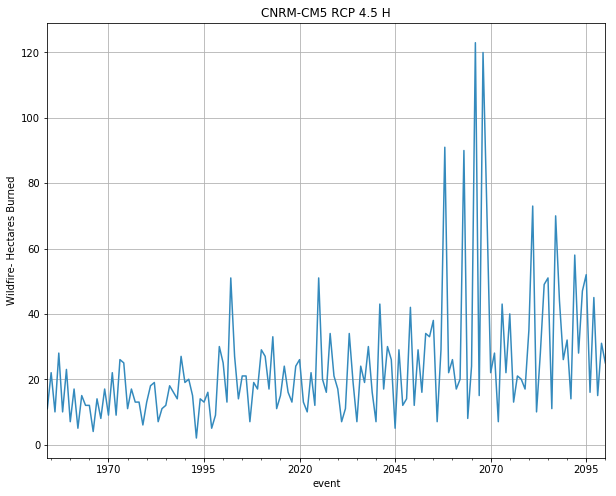

In [9]:
fire_df['fire_rcp45_H'].plot(figsize=(10, 8), color='#348ABD')
plt.title("CNRM-CM5 RCP 4.5 H")
plt.ylabel("Wildfire- Hectares Burned")
plt.grid(True)

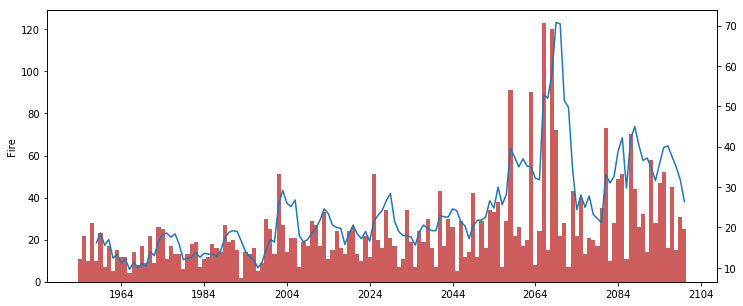

In [10]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(fire_df.index, fire_df['fire_rcp45_H'], width=365, facecolor='indianred')
ax1.set_ylabel('Fire')
# horizontal line indicating 5 year rolling mean
rolling_mean = fire_df['fire_rcp45_H'].rolling(5).mean()
ax2 = ax1.twinx()
ax2.plot(rolling_mean)

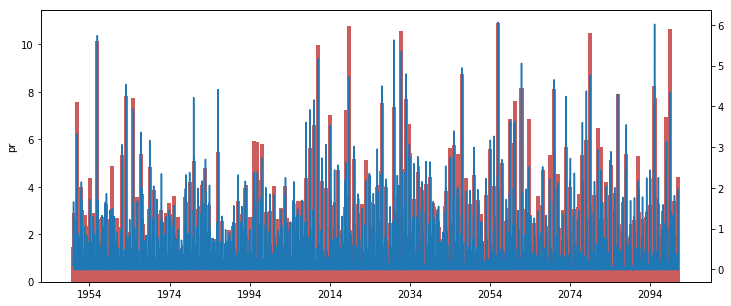

In [11]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(pr_df.index, pr_df['pr'], width=365, facecolor='indianred')
ax1.set_ylabel('pr')
# horizontal line indicating 5 year rolling mean
rolling_mean = pr_df['pr'].rolling(5).mean()
ax2 = ax1.twinx()
ax2.plot(rolling_mean)

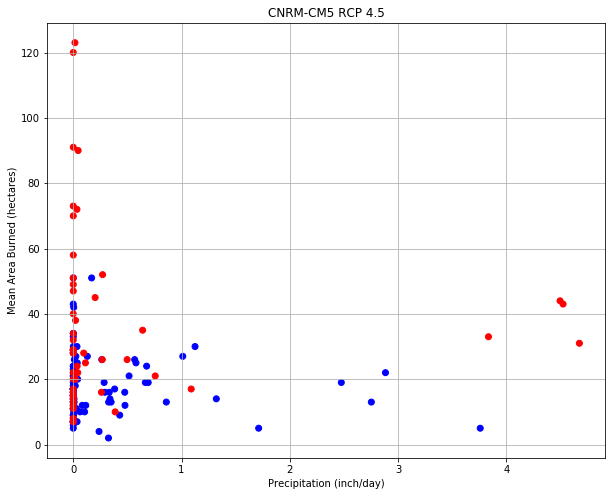

In [14]:
df = pd.merge(pr_df,fire_df, left_index=True, right_index=True)
df['color'] = np.where(df.index.year >= 2050, 'red', 'blue')

# Scatter plot
plt.figure(figsize=(10,8)) 
plt.scatter(df['pr'], df['fire_rcp45_H'], color=df['color'])
plt.title("CNRM-CM5 RCP 4.5")
plt.ylabel("Mean Area Burned (hectares)")
plt.xlabel("Precipitation (inch/day)")
plt.grid(True)

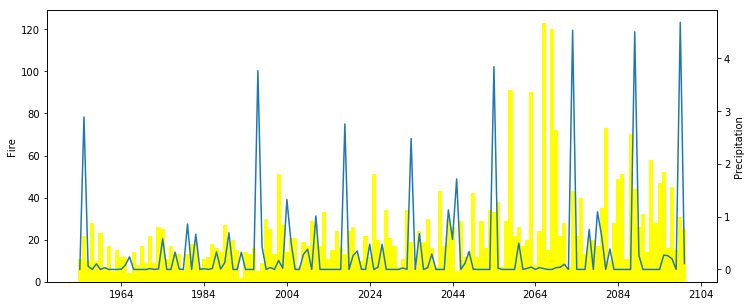

In [15]:
fig, barax = plt.subplots(figsize=(12,5))
tsax = barax.twinx()

tsax.plot(df.index, df['pr'])
tsax.set_ylabel('Precipitation')

# the `width` is specified in days -- adjust for your data
barax.bar(df.index, df['fire_rcp45_H'], width=365, facecolor='yellow')
barax.set_ylabel('Fire')